In [160]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [161]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

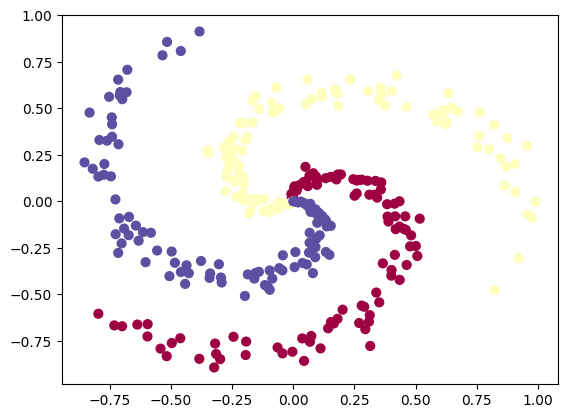

In [162]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [163]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [164]:
RANDOM_SEED = 42

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

len(X_tr), len(X_te), len(y_tr), len(y_te)

(240, 60, 240, 60)

In [165]:
X_tr = X_tr.to(device)
X_te = X_te.to(device)
y_tr = y_tr.to(device)
y_te = y_te.to(device)

In [166]:
X_tr[:5], y_tr[:5]

(tensor([[ 0.1480, -0.2874],
         [ 0.3392, -0.4900],
         [ 0.0143,  0.0589],
         [ 0.6328,  0.5803],
         [ 0.5719,  0.4655]], device='cuda:0'),
 tensor([2, 0, 0, 1, 1], device='cuda:0'))

In [167]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.Tanh(),
            nn.Linear(in_features=10, out_features=5),
            nn.Tanh(),
            nn.Linear(in_features=5, out_features=3),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [168]:
model = Model().to(device)
model

Model(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=5, bias=True)
    (3): Tanh()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [169]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [170]:
logits = model(X_tr)

In [171]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_true)) * 100

In [172]:
torch.manual_seed(42)

iterations = 100

for i in range(iterations):
    model.train()

    logits = model(X_tr)
    logits_pred = torch.softmax(logits, dim=1).argmax(dim=1)

    acc = accuracy_fn(y_true=y_tr, y_pred=logits_pred)
    loss = loss_fn(logits, y_tr)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if i % 10 == 0:
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_te)
            test_logits_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss = loss_fn(test_logits, y_te)
            test_acc = accuracy_fn(y_true=y_te, y_pred=test_logits_pred)

        print(f'Iteration {i}: LOSS: {loss:.5f} | ACCURACY: {acc:.1f}% | TEST_LOSS: {test_loss:.5f} | TEST ACCURACY: {test_acc:.1f}%')
        
print(f'Iteration {i+1}: LOSS: {loss:.5f} | ACCURACY: {acc:.1f}% | TEST_LOSS: {test_loss:.5f} | TEST ACCURACY: {test_acc:.1f}%')
    

Iteration 0: LOSS: 1.15133 | ACCURACY: 35.0% | TEST_LOSS: 1.05619 | TEST ACCURACY: 41.7%
Iteration 10: LOSS: 0.75359 | ACCURACY: 64.6% | TEST_LOSS: 0.85805 | TEST ACCURACY: 45.0%
Iteration 20: LOSS: 0.60725 | ACCURACY: 74.6% | TEST_LOSS: 0.65746 | TEST ACCURACY: 66.7%
Iteration 30: LOSS: 0.39459 | ACCURACY: 87.5% | TEST_LOSS: 0.47438 | TEST ACCURACY: 75.0%
Iteration 40: LOSS: 0.28146 | ACCURACY: 87.5% | TEST_LOSS: 0.33746 | TEST ACCURACY: 81.7%
Iteration 50: LOSS: 0.19819 | ACCURACY: 92.1% | TEST_LOSS: 0.17028 | TEST ACCURACY: 95.0%
Iteration 60: LOSS: 0.11506 | ACCURACY: 95.8% | TEST_LOSS: 0.07886 | TEST ACCURACY: 96.7%
Iteration 70: LOSS: 0.07464 | ACCURACY: 97.1% | TEST_LOSS: 0.05020 | TEST ACCURACY: 100.0%
Iteration 80: LOSS: 0.06021 | ACCURACY: 97.5% | TEST_LOSS: 0.03478 | TEST ACCURACY: 100.0%
Iteration 90: LOSS: 0.05193 | ACCURACY: 97.9% | TEST_LOSS: 0.03011 | TEST ACCURACY: 100.0%
Iteration 100: LOSS: 0.04669 | ACCURACY: 98.3% | TEST_LOSS: 0.03011 | TEST ACCURACY: 100.0%


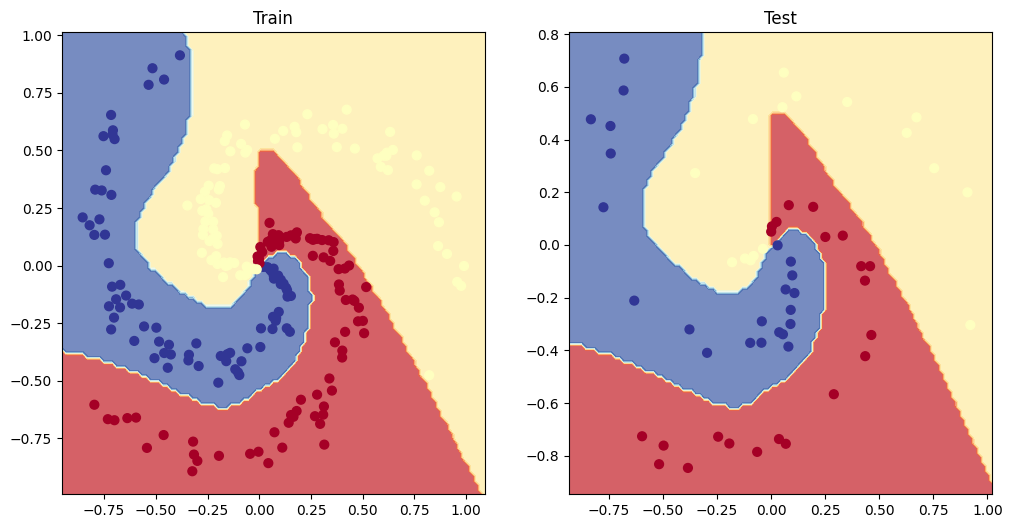

In [173]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_tr, y_tr)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_te, y_te)